## CMU16-745 (2024)lecture 3

File : root-finding.ipynb

Note: use np.linalg.solve(A,B) in place of A\B


In [1]:
import numpy as np 
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt 


In [2]:
def pendulum_dynamics(x):
    l = 1.0
    g = 9.81
    theta = x[0]
    theta_dot = x[1]
    theta_ddot = -(g/l)*np.sin(theta)
    return np.array([theta_dot,theta_ddot]) 

In [3]:
# use this function wrapper to handle Newton method because Drake forwarddiff 
# works with only one argument function
def pendulum_dynamics_wrapper(x):
    global _x0, _h
    return _x0 + _h*pendulum_dynamics(x) - x

In [17]:
def backward_euler_step_fixed_point(func, x0, h):
    xn = x0
    e = [norm(x0 + h*func(xn) - xn)]
    while e[-1] > 1e-8:
        xn = x0 + h*func(xn)
        # e = [e, norm(x0 + h*func(xn) - xn)]
        e.append(norm(x0 + h*func(xn) - xn))
    
    return xn, e

In [5]:
from pydrake import forwarddiff

In [21]:
# use pendulum_dynamics_wrapper() in func argument
def backward_euler_step_newton(func, x0, h):
    global _x0, _h
    _x0 = x0
    _h = h
    xn = x0
    r = func(xn)
    e = [norm(r)]
    while e[-1] > 1e-8:
        dr = forwarddiff.jacobian(func, xn)
        xn = xn - solve(dr,r) # use solve(A,B) in place of A\B
        r = func(xn)
        e.append(norm(r))
    
    return xn, e

In [7]:
def backward_euler_fixed_point(func, x0, Tf, h):
    t = np.arange(0,Tf,h)
    x_hist = np.zeros((len(x0),len(t)))
    x_hist[:,0] = x0
    for k in range(len(t)-1):
        x_hist[:,k+1],e = backward_euler_step_fixed_point(func,x_hist[:,k],h)
    
    return x_hist, t

In [19]:
def backward_euler_newton(func, x0, Tf, h):
    global _x0, _h
    t = np.arange(0,Tf,h)
    x_hist = np.zeros((len(x0),len(t)))
    x_hist[:,0] = x0
    _x0 = x0
    _h = h
    for k in range(len(t)-1):
        x_hist[:,k+1],e = backward_euler_step_newton(func,x_hist[:,k],h)
    
    return x_hist, t

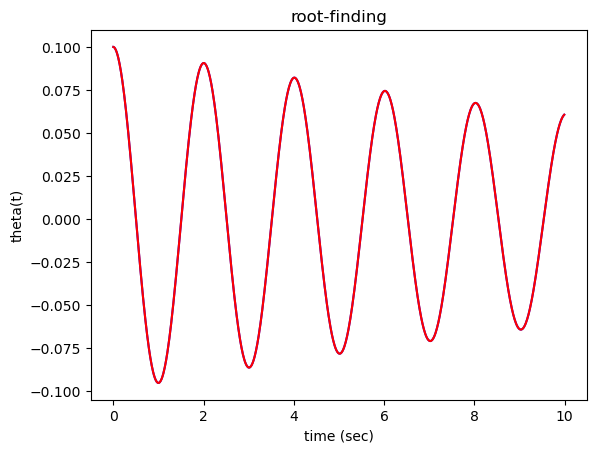

In [22]:
x0 = np.array([.1,0])
_x0 = x0
_h = 0.01
x_hist1, t_hist1 = backward_euler_fixed_point(pendulum_dynamics, x0, 10, 0.01)
x_hist2, t_hist2 = backward_euler_newton(pendulum_dynamics_wrapper, x0, 10, 0.01)

plt.figure()
plt.plot(t_hist1, x_hist1[0,:],'b-',t_hist2, x_hist2[0,:],'r-')
plt.xlabel('time (sec)')
plt.ylabel('theta(t)')
plt.title('root-finding')
plt.show()

In [18]:
xn, e1 = backward_euler_step_fixed_point(pendulum_dynamics, x0, 0.1)
e1

[0.09793658173053843,
 0.009793658173053846,
 0.009564124766684667,
 0.0009564124766684723,
 0.0009343853483241293,
 9.343853483241571e-05,
 9.128296581455142e-05,
 9.128296581450979e-06,
 8.917746787032166e-06,
 8.917746786990532e-07,
 8.712050176828967e-07,
 8.712050177106523e-08,
 8.511098474606182e-08,
 8.511098478769519e-09]

In [23]:
xn, e2 = backward_euler_step_newton(pendulum_dynamics_wrapper, x0, 0.1)
e2

[0.09793658173053843, 3.7830087232931797e-06, 5.2874553670659e-15]

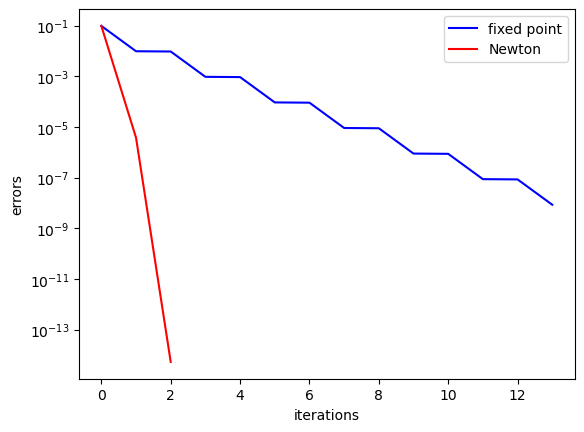

In [27]:
plt.figure()
plt.semilogy(e1,'b',e2,'r')
plt.xlabel('iterations')
plt.ylabel('errors')
plt.legend(['fixed point','Newton'])
plt.show()